In [1]:
import os
import dianna
import onnx
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

In [2]:
# load data
dataset_root = os.path.expanduser('~/projects/DIANNA/datasets/leafsnap/leafsnap-dataset-30subset')
img_size = 128
# apply same transform as during training: resize and crop to a square image, then convert to tensor
transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor()])

test_data = datasets.ImageFolder(os.path.join(dataset_root, 'dataset/split/test'), transform=transform,
                                 is_valid_file=lambda fname: fname.endswith('.jpg'))
nsample = len(test_data)
nspecies = len(test_data.classes)
print(f'Number of samples: {nsample}')
print(f'Number of species: {nspecies}')

X_test = np.array([instance[0].numpy() for instance in test_data])
X_test = np.transpose(X_test, (0, 2, 3, 1))
y_test = np.array([instance[1] for instance in test_data])

Number of samples: 739
Number of species: 30


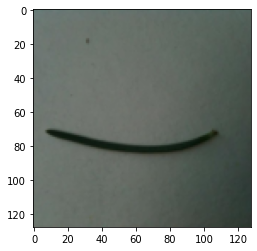

In [3]:
X_test.shape
plt.imshow(X_test[0])

# Predict classes for test data

In [4]:
from scipy.special import softmax

def run_model(data):
    data = np.transpose(data, (0, 3, 1, 2)).astype(np.float32)
    fname = os.path.expanduser('~/surfdrive/Shared/datasets/leafsnap/leafsnap_model.onnx')
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)


pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data

2
[2.2263842e-11 8.8479817e-07 9.9706697e-01 2.5346053e-03 6.8168029e-06
 9.8773878e-09 6.9872258e-05 2.5941175e-05 2.7593690e-06 4.0837489e-10
 1.5737007e-06 6.1076668e-09 1.4814456e-08 1.3469712e-05 4.6744173e-08
 2.3746741e-08 1.6557478e-05 5.4702246e-06 5.0416776e-07 2.0181572e-11
 1.5110372e-07 1.2924235e-06 3.2731759e-07 3.1940556e-07 9.1364069e-07
 1.0909525e-08 1.2453539e-07 6.8950058e-06 7.5442019e-10 2.4445236e-04]


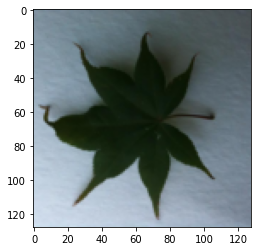

In [5]:
i_instance = 50
target_class = y_test[i_instance]
print(target_class)
print(pred_onnx[i_instance])
plt.imshow(X_test[i_instance])  # 0 for channel

In [6]:
# heatmaps = dianna.explain(run_model, X_test[[i_instance]], method="RISE", n_masks=2000, feature_res=8)

In [13]:
from dianna.methods import RISE
explainer = RISE(n_masks=2000, feature_res=16)
heatmaps = explainer(run_model, X_test[[i_instance]])

Explaining: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


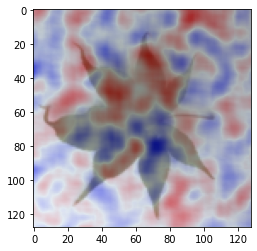

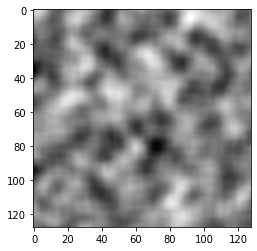

In [14]:
from dianna import visualization
visualization.plot_image(heatmaps[target_class], X_test[i_instance], heatmap_cmap='bwr')
visualization.plot_image(heatmaps[target_class], heatmap_cmap='gray')

In [9]:
def describe(arr):
    print('shape:',arr.shape, 'min:',np.min(arr), 'max:',np.max(arr), 'std:',np.std(arr))

describe(heatmaps[target_class])
# describe(heatmaps[1])

shape: (128, 128) min: 0.8863057164058157 max: 0.9912296933227568 std: 0.015000484987393517


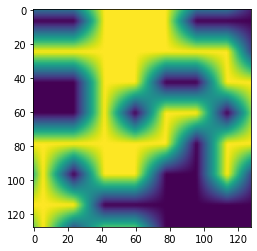

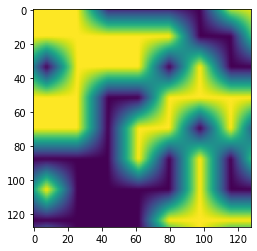

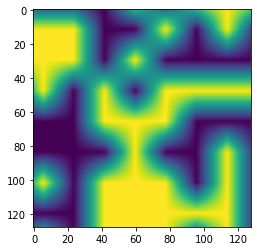

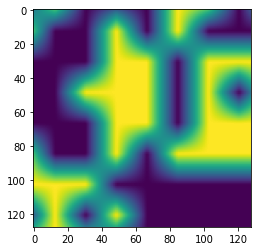

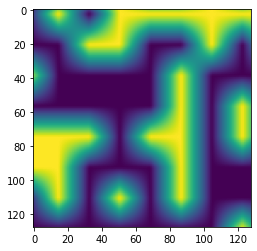

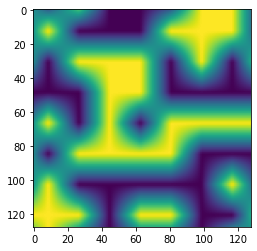

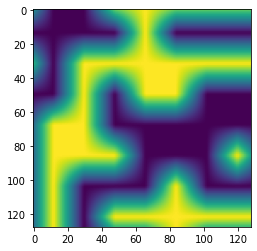

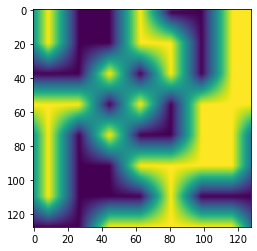

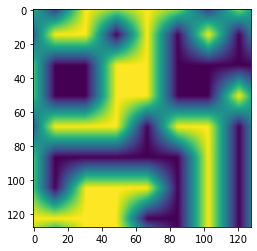

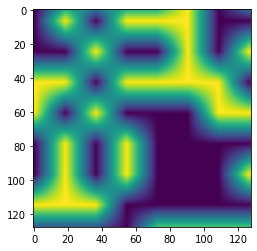

In [10]:
for i in range(10):
    plt.imshow(explainer.masks[i])
    plt.show()